In [196]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',40)
warnings.filterwarnings('ignore')

In [197]:
HR_Analytics = pd.read_csv('HR_Analytics.csv')
print(HR_Analytics.head())
print(HR_Analytics.info())

   EmpID  Age AgeGroup Attrition     BusinessTravel  DailyRate  \
0  RM297   18    18-25       Yes      Travel_Rarely        230   
1  RM302   18    18-25        No      Travel_Rarely        812   
2  RM458   18    18-25       Yes  Travel_Frequently       1306   
3  RM728   18    18-25        No         Non-Travel        287   
4  RM829   18    18-25       Yes         Non-Travel        247   

               Department  DistanceFromHome  Education EducationField  \
0  Research & Development                 3          3  Life Sciences   
1                   Sales                10          3        Medical   
2                   Sales                 5          3      Marketing   
3  Research & Development                 5          2  Life Sciences   
4  Research & Development                 8          1        Medical   

   EmployeeCount  EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  \
0              1             405                        3    Male          54   
1 

In [198]:
column_list = HR_Analytics.columns
for column in column_list:
    print(column,': ',HR_Analytics[column].unique())

EmpID :  ['RM297' 'RM302' 'RM458' ... 'RM537' 'RM880' 'RM1210']
Age :  [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
AgeGroup :  ['18-25' '26-35' '36-45' '46-55' '55+']
Attrition :  ['Yes' 'No']
BusinessTravel :  ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel' 'TravelRarely']
DailyRate :  [ 230  812 1306  287  247 1124  544 1431  528 1181  602  303  489  419
  645  504  265  871  959 1362  500  129 1097  769  805  654 1141  727
  391  996  756  895  156 1343 1427 1334  984  251  546  337  501 1123
  534  594 1256 1136  253 1368  604 1230  617  217  457 1294  581  541
 1309  885  650  310 1243  373  507  977 1320  427  160  571  638  673
  813 1353 1127 1371 1448  535  691  823 1287  693 1092 1269 1206  477
 1476  381  830  350  567  240  506  897  771 1280  685  675  891  688
  622  810  883  180  141  583  867 1219 1356  599  266  882 1372  949
  383  772  309 1382 1357 1443  841 1355 1479  496 144

In [199]:
HR_Analytics = HR_Analytics.drop(['YearsInCurrentRole','Age','DailyRate','EmployeeCount','EmployeeNumber','MonthlyRate','SalarySlab','Over18','EmpID','StandardHours','MonthlyIncome'],axis = 1)


In [200]:
encode_age = {
    '18-25':0,
    '26-35':1,
    '36-45':2,
    '46-55':3,
    '55+':4 
}
encode_travel = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'TravelRarely': 1,
    'Travel_Frequently': 2
}
encode_yes_no = {
    'Yes' : 1,
    'No' : 0
}
encode_gender = {
    'Male':1,
    'Female':0
}
def age_group_encode(row):
    global encode_age,encode_yes_no,encode_gender
    row['AgeGroup_encoded'] = encode_age[row['AgeGroup']]
    row['BusinessTravel_encoded'] = encode_travel[row['BusinessTravel']]
    row['OverTime_encoded'] = encode_yes_no[row['OverTime']]
    row['Attrition_encoded'] = encode_yes_no[row['Attrition']]
    row['Gender_encoded'] = encode_gender[row['Gender']]
    return row
HR_Analytics['YearsWithCurrManager'] = HR_Analytics['YearsWithCurrManager'].fillna(HR_Analytics['YearsSinceLastPromotion'])
HR_Analytics = HR_Analytics.apply(age_group_encode,axis = 1)

In [201]:
onehot_columns = ['Department', 'EducationField','JobRole','MaritalStatus']
one_hot_encoded_df = pd.get_dummies(HR_Analytics[onehot_columns], prefix=onehot_columns, prefix_sep='_encoded', drop_first=False)

# Concatenate the original HR_Analytics DataFrame with the new one-hot encoded columns
HR_Analytics_encoded = pd.concat([HR_Analytics, one_hot_encoded_df], axis=1)

(HR_Analytics_encoded.head())
encoded_df = HR_Analytics_encoded.drop(['AgeGroup','BusinessTravel','Attrition', 'Department', 'EducationField','Gender','JobRole','MaritalStatus','OverTime'],axis = 1)

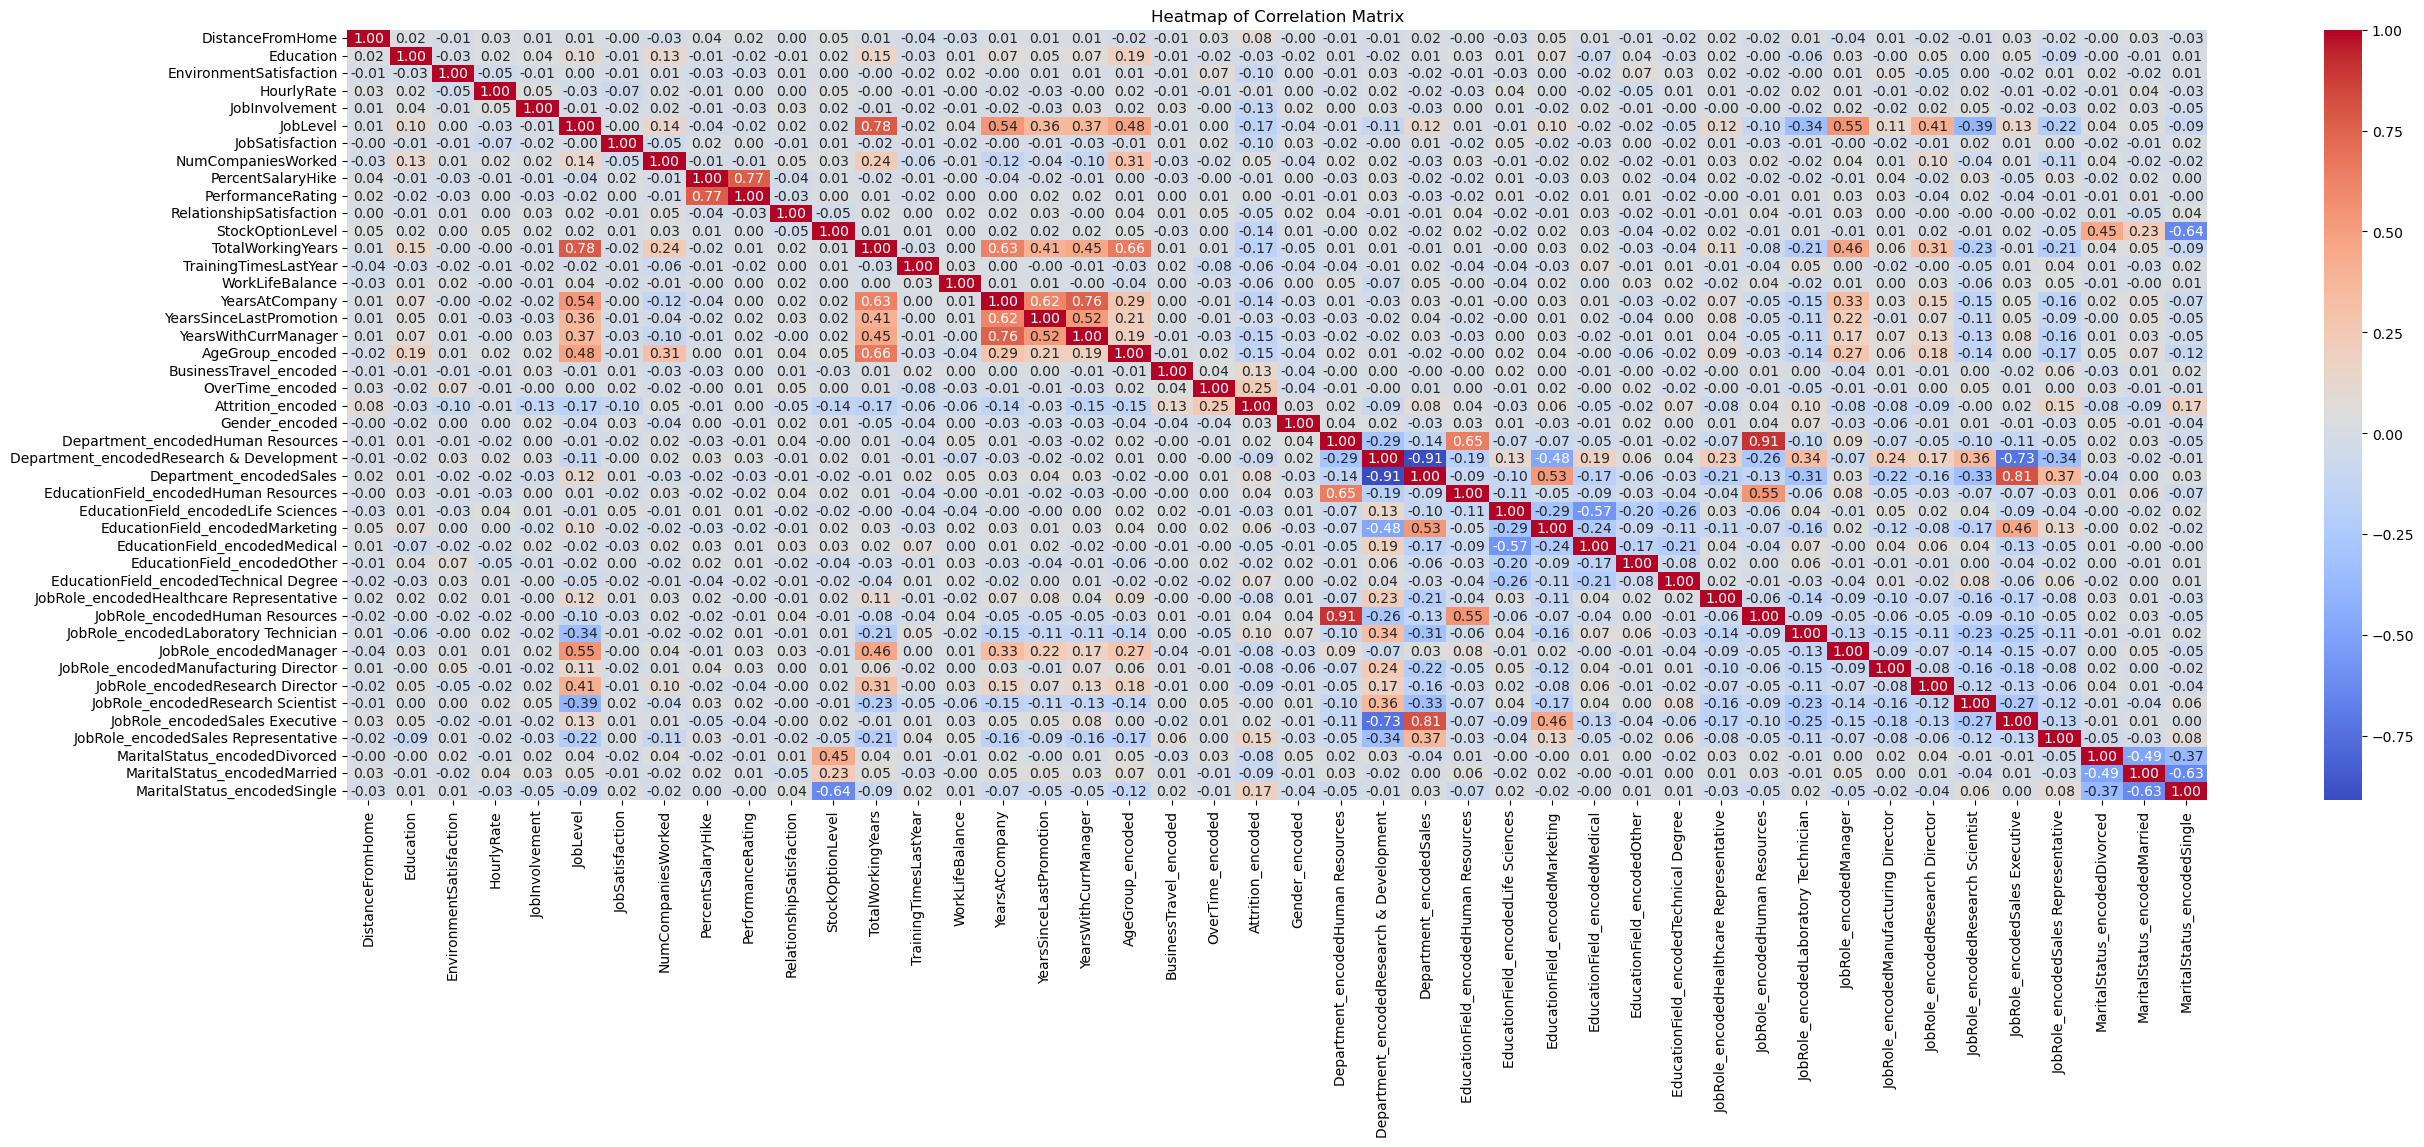

In [202]:
correlation_matrix = encoded_df.corr()
plt.figure(figsize=(30, 10))  # Adjust the size of the heatmap as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [203]:
variables = encoded_df.columns.drop('Attrition_encoded').tolist()
chi_squared_results = []

for var in variables:
    crosstab = pd.crosstab(encoded_df[var], encoded_df['Attrition_encoded'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi_squared_results.append({'Variable': var, 'Chi2': chi2, 'P-value': p})

# Convert results into a DataFrame
chi_squared_df = pd.DataFrame(chi_squared_results)

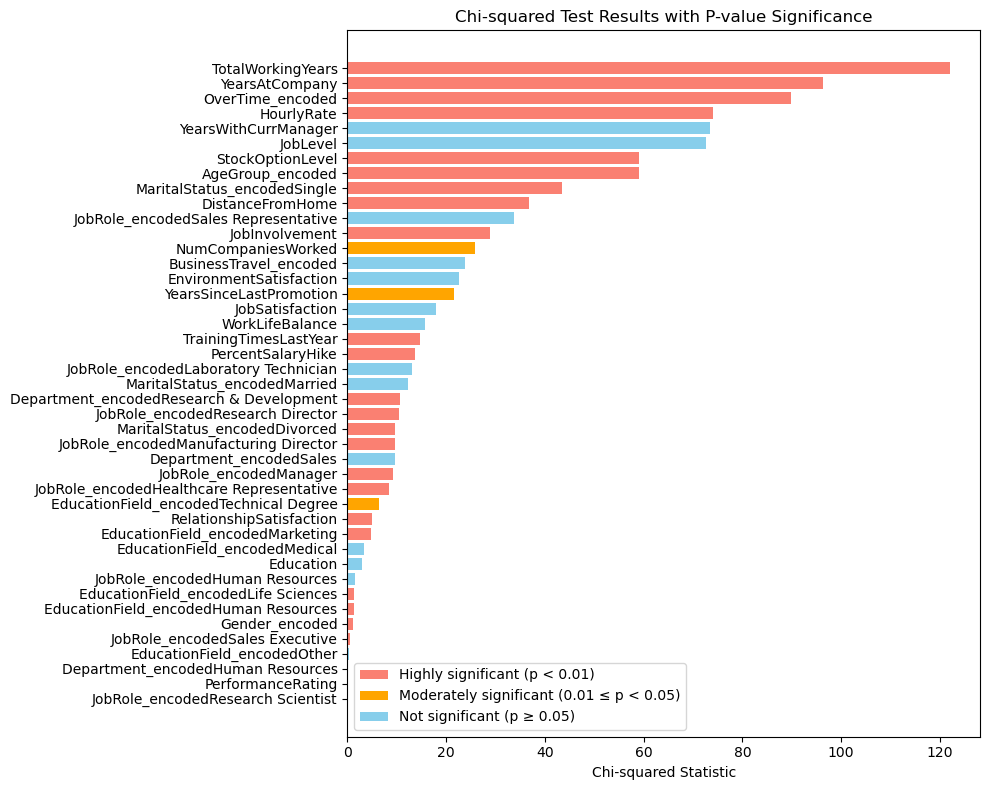

In [204]:
def categorize_pvalue(p):
    if p < 0.01:
        return 'salmon'  # Highly significant
    elif p < 0.05:
        return 'orange'  # Moderately significant
    else:
        return 'skyblue'  # Not significant

# Apply the function to create a list of colors for each p-value
colors = chi_squared_df['P-value'].apply(categorize_pvalue)

# Sorting the DataFrame by P-value for better visualization
chi_squared_df_sorted = chi_squared_df.sort_values(by='Chi2', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(chi_squared_df_sorted['Variable'], chi_squared_df_sorted['Chi2'], color=colors)

plt.xlabel('Chi-squared Statistic')
plt.title('Chi-squared Test Results with P-value Significance')
plt.tight_layout()

# Create custom legends
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='salmon', label='Highly significant (p < 0.01)'),
                   Patch(facecolor='orange', label='Moderately significant (0.01 ≤ p < 0.05)'),
                   Patch(facecolor='skyblue', label='Not significant (p ≥ 0.05)')]
plt.legend(handles=legend_elements, loc='best')

# Show plot
plt.show()

In [205]:
scaler = MinMaxScaler()

# Select columns to scale - in this case, we're scaling all columns
columns_to_scale = encoded_df.columns

# Apply MinMaxScaler to all columns
encoded_df[columns_to_scale] = scaler.fit_transform(encoded_df[columns_to_scale])

# Display the first few rows to verify the normalization
print(encoded_df.head(10))

   DistanceFromHome  Education  EnvironmentSatisfaction  HourlyRate  \
0          0.071429       0.50                 0.666667    0.342857   
1          0.321429       0.50                 1.000000    0.557143   
2          0.142857       0.50                 0.333333    0.557143   
3          0.142857       0.25                 0.333333    0.614286   
4          0.250000       0.00                 0.666667    0.714286   
5          0.000000       0.50                 1.000000    0.957143   
6          0.071429       0.25                 0.333333    0.571429   
7          0.464286       0.50                 0.333333    0.042857   
8          0.750000       0.00                 1.000000    0.285714   
9          0.071429       0.00                 0.333333    0.700000   

   JobInvolvement  JobLevel  JobSatisfaction  NumCompaniesWorked  \
0        0.666667       0.0         0.666667            0.111111   
1        0.333333       0.0         0.666667            0.111111   
2        0.666

In [206]:
encoded_df['YearsWithCurrManager'].unique()

array([0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
       0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
       0.58823529, 0.70588235, 0.76470588, 0.64705882, 0.88235294,
       0.82352941, 1.        , 0.94117647])

In [207]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import numpy as np


In [208]:
X = encoded_df.drop('Attrition_encoded', axis=1)
y = encoded_df['Attrition_encoded']

In [209]:
split_ratios = [0.5, 0.4, 0.3, 0.2, 0.1]
average_metrics = {
    'Split Ratio': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

In [210]:
def calculate_avg_metrics(cv_results):
    metrics = {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'F1 Score': np.mean(cv_results['test_f1'])
    }
    return metrics

In [211]:
for test_size in split_ratios:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Initialize the logistic regression model
    model = LogisticRegression(solver='liblinear', random_state=42)
    
    # Set up Stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {'accuracy': 'accuracy', 'precision': make_scorer(precision_score, zero_division=0),'recall': 'recall', 'f1': 'f1'}
    
    # Perform cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    
    # Calculate and store average metrics
    avg_metrics = calculate_avg_metrics(cv_results)
    average_metrics['Split Ratio'].append(f"{int((1-test_size)*100)}-{int(test_size*100)}")
    for metric in avg_metrics:
        average_metrics[metric].append(avg_metrics[metric])

# Convert the results to a DataFrame for easier viewing
average_metrics_df = pd.DataFrame(average_metrics)
print(average_metrics_df)

  Split Ratio  Accuracy  Precision    Recall  F1 Score
0       50-50  0.856757   0.634524  0.252899  0.357334
1       60-40  0.864896   0.716361  0.266749  0.384606
2       70-30  0.860986   0.681459  0.274510  0.382438
3       80-20  0.870800   0.709675  0.331579  0.448230
4       90-10  0.870871   0.688254  0.345958  0.453682


In [216]:
C_values = [0.01,0.015,0.02,0.03,0.045,0.068,0.01,0.015,0.02,0.03,0.045,0.065,1,1.45,2.1,3,4.5,6.5,10,14,21,31.5,46,65,100]  # Set of C values
penalties = ['l1', 'l2']  # Regularization types

# List to store results
results = []

# Define k-fold cross-validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through penalties and C values
for penalty in penalties:
    for C in C_values:
        model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42)
        
        # Define scoring metrics for cross-validation
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        
        # Perform cross-validation
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
        
        # Use the previously defined function to calculate average metrics
        avg_metrics = calculate_avg_metrics(cv_results)
        
        # Append results including penalty and C value
        results.append({
            'Penalty': penalty,
            'C': C,
            **avg_metrics  # Unpack average metrics directly into the dictionary
        })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

In [218]:
results_df

,Penalty,C,Accuracy,Precision,Recall,F1 Score
0,l1,0.010,0.839189,0.000000,0.000000,0.000000
1,l1,0.015,0.839189,0.000000,0.000000,0.000000
2,l1,0.020,0.839189,0.000000,0.000000,0.000000
3,l1,0.030,0.839189,0.000000,0.000000,0.000000
4,l1,0.045,0.839189,0.000000,0.000000,0.000000
5,l1,0.068,0.843243,0.800000,0.025177,0.048653
6,l1,0.010,0.839189,0.000000,0.000000,0.000000
7,l1,0.015,0.839189,0.000000,0.000000,0.000000
8,l1,0.020,0.839189,0.000000,0.000000,0.000000
9,l1,0.030,0.839189,0.000000,0.000000,0.000000


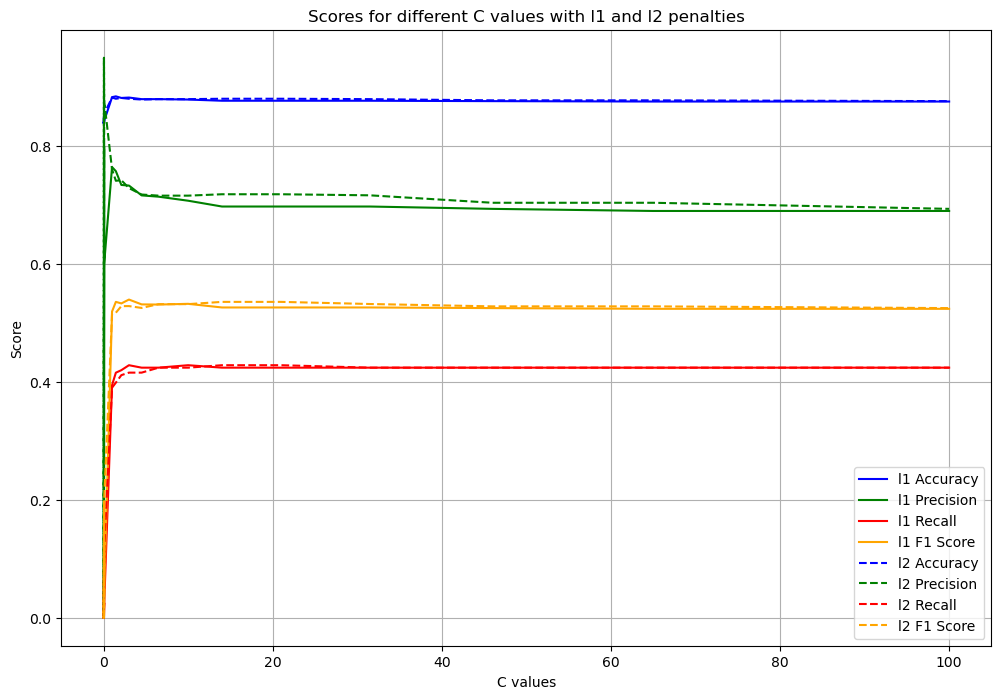

In [214]:
l1_data = results_df[results_df['Penalty'] == 'l1']
l2_data = results_df[results_df['Penalty'] == 'l2']

# Plotting
plt.figure(figsize=(12, 8))

# Plotting for l1
plt.plot(l1_data['C'], l1_data['Accuracy'], label='l1 Accuracy', color='blue')
plt.plot(l1_data['C'], l1_data['Precision'], label='l1 Precision', color='green')
plt.plot(l1_data['C'], l1_data['Recall'], label='l1 Recall', color='red')
plt.plot(l1_data['C'], l1_data['F1 Score'], label='l1 F1 Score', color='orange')

# Plotting for l2
plt.plot(l2_data['C'], l2_data['Accuracy'], label='l2 Accuracy', linestyle='--', color='blue')
plt.plot(l2_data['C'], l2_data['Precision'], label='l2 Precision', linestyle='--', color='green')
plt.plot(l2_data['C'], l2_data['Recall'], label='l2 Recall', linestyle='--', color='red')
plt.plot(l2_data['C'], l2_data['F1 Score'], label='l2 F1 Score', linestyle='--', color='orange')

# Set labels and title
plt.xlabel('C values')
plt.ylabel('Score')
plt.title('Scores for different C values with l1 and l2 penalties')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [182]:
# Fit a Logistic Regression model with L1 regularization (Lasso)
ridge_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42)
ridge_model.fit(X_train, y_train)

# Get the coefficients from the model
coefficients = ridge_model.coef_[0]

# Create a DataFrame for easier viewing of feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Absolute Coefficient': abs(coefficients)
})

# Sort the features by absolute coefficient value in descending order
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False).reset_index(drop=True)


# Assuming 'feature_importance' is your DataFrame from Logistic Regression
# Extract Absolute Coefficient values for normalization
abs_coefficients = feature_importance[['Absolute Coefficient']].values

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the absolute coefficients so that they are between 0 and 1
feature_importance['Normalized Coefficient'] = scaler.fit_transform(abs_coefficients)

In [183]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
rf_best = rf_grid_search.best_estimator_
rf_predictions = rf_best.predict(X_test)
print(classification_report(y_test, rf_predictions))

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       248
         1.0       0.90      0.19      0.31        48

    accuracy                           0.86       296
   macro avg       0.88      0.59      0.62       296
weighted avg       0.87      0.86      0.83       296



In [185]:
feature_importances = rf_best.feature_importances_

# Create a pandas DataFrame for easier visualization
features_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is your feature DataFrame
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
rf_features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Scale the Random Forest importances
rf_features_df['Scaled Importance'] = scaler.fit_transform(rf_features_df[['Importance']])



In [186]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, cv=5, scoring='f1')
xgb_grid_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
xgb_best = xgb_grid_search.best_estimator_
xgb_predictions = xgb_best.predict(X_test)
print(classification_report(y_test, xgb_predictions))

Best parameters for XGBoost: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       248
         1.0       0.78      0.44      0.56        48

    accuracy                           0.89       296
   macro avg       0.84      0.71      0.75       296
weighted avg       0.88      0.89      0.88       296



In [187]:
feature_importances = xgb_best.feature_importances_

# Create a pandas DataFrame for easier visualization
features_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is your feature DataFrame
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
xgb_features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Scale the Random Forest importances
xgb_features_df['Scaled Importance'] = scaler.fit_transform(xgb_features_df[['Importance']])


In [188]:
# First, merge the Random Forest and XGBoost feature importance DataFrames
merged_df = pd.merge(rf_features_df[['Feature', 'Scaled Importance']],
                     xgb_features_df[['Feature', 'Scaled Importance']],
                     on='Feature',
                     suffixes=('_RF', '_XGB'))

# Now, merge the combined DataFrame with the Logistic Regression feature importance DataFrame
# Assuming 'feature_importance' DataFrame contains the Logistic Regression coefficients with columns 'Feature' and 'Normalized Coefficient'
final_merged_df = pd.merge(merged_df,
                           feature_importance[['Feature', 'Normalized Coefficient']],
                           on='Feature')

# Rename the columns appropriately
final_merged_df.rename(columns={'Scaled Importance_RF': 'RF Importance',
                                'Scaled Importance_XGB': 'XGB Importance',
                                'Normalized Coefficient': 'LR Coefficient'}, inplace=True)

final_merged_df = final_merged_df.sort_values(by='XGB Importance', ascending=False).reset_index(drop=True)



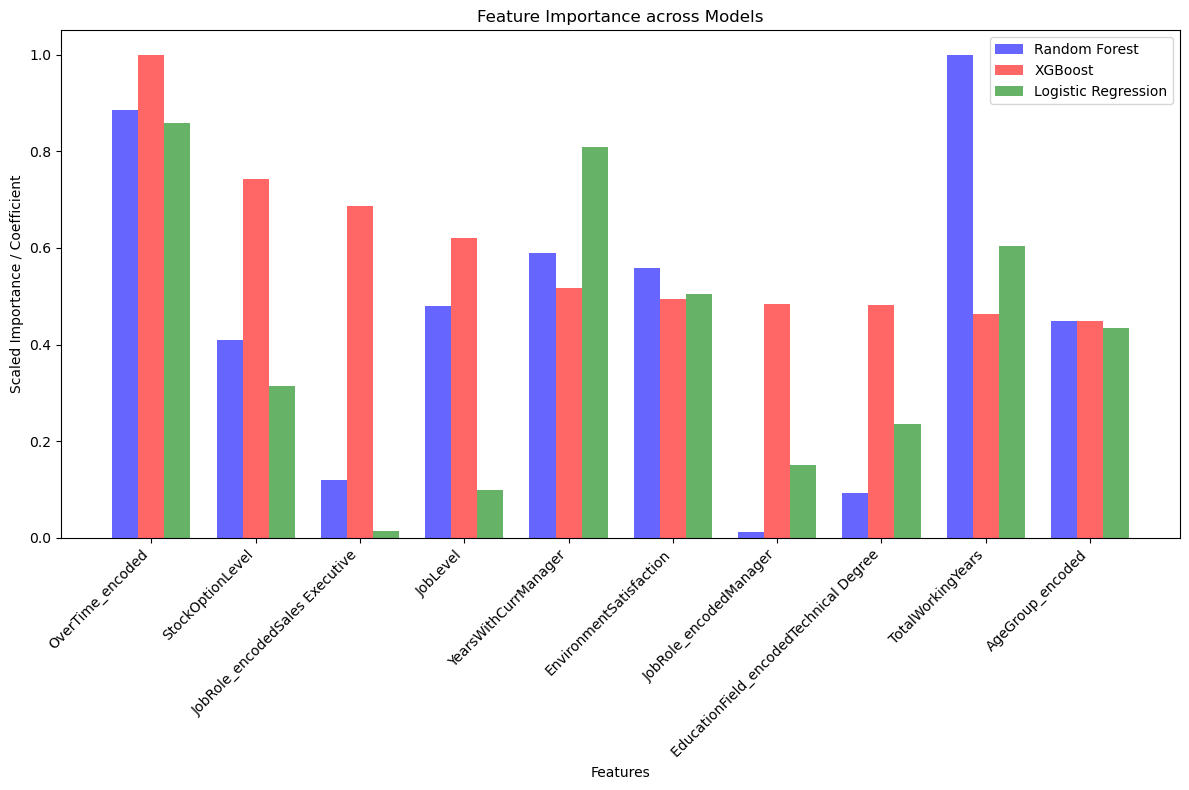

In [189]:
N = 10
top_features = final_merged_df.head(N)

# Setting up the plot
plt.figure(figsize=(12, 8))

# Range for the number of features
index = np.arange(N)
bar_width = 0.25

# Plotting RF Importance
plt.bar(index, top_features['RF Importance'], bar_width, label='Random Forest', color='b', alpha=0.6)

# Plotting XGB Importance
plt.bar(index + bar_width, top_features['XGB Importance'], bar_width, label='XGBoost', color='r', alpha=0.6)

# Plotting LR Coefficient
plt.bar(index + 2*bar_width, top_features['LR Coefficient'], bar_width, label='Logistic Regression', color='g', alpha=0.6)

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Scaled Importance / Coefficient')
plt.title('Feature Importance across Models')
plt.xticks(index + bar_width, top_features['Feature'], rotation=45, ha="right")
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

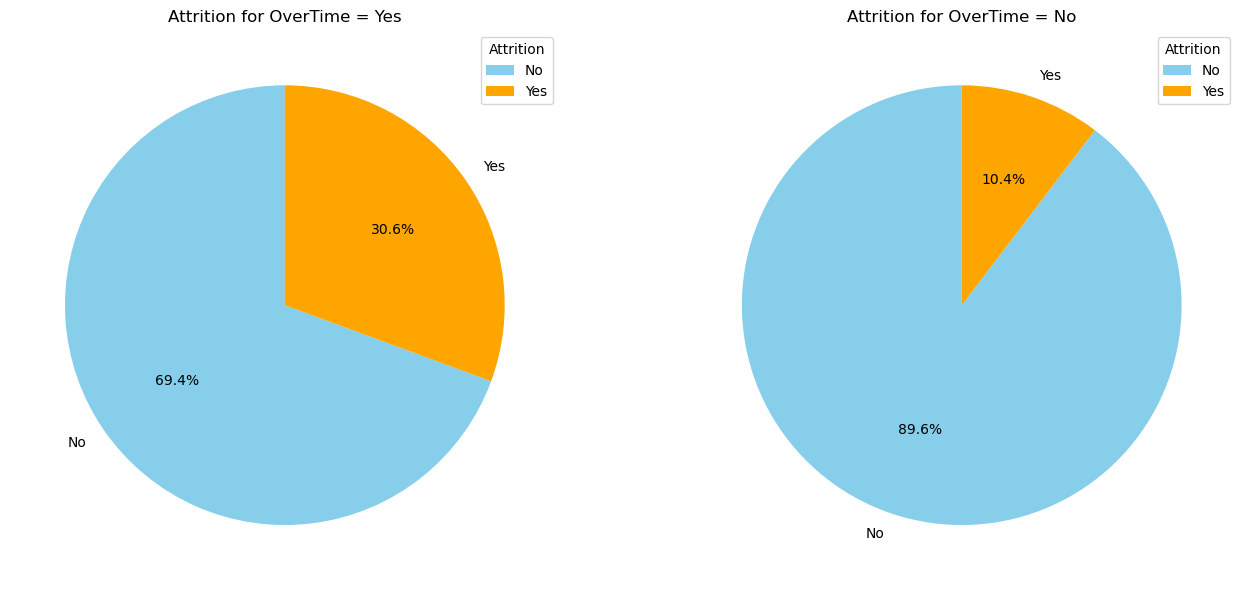

In [190]:
overtime_yes_attrition = HR_Analytics[HR_Analytics['OverTime'] == 'Yes']['Attrition'].value_counts()

# Filter data for OverTime = 'No' and count 'Attrition' occurrences
overtime_no_attrition = HR_Analytics[HR_Analytics['OverTime'] == 'No']['Attrition'].value_counts()

# Setting up the figure for pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for employees with OverTime = 'Yes'
wedges, texts, autotexts = axes[0].pie(overtime_yes_attrition, labels=overtime_yes_attrition.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
axes[0].set_title('Attrition for OverTime = Yes')
axes[0].legend(wedges, overtime_yes_attrition.index, title="Attrition", loc="best")

# Pie chart for employees with OverTime = 'No'
wedges, texts, autotexts = axes[1].pie(overtime_no_attrition, labels=overtime_no_attrition.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
axes[1].set_title('Attrition for OverTime = No')
axes[1].legend(wedges, overtime_no_attrition.index, title="Attrition", loc="best")

# Display the plots
plt.tight_layout()
plt.show()

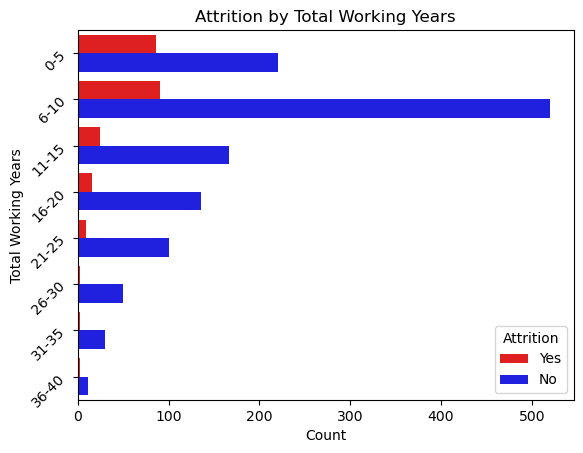

In [191]:
HR_Analytics['TotalWorkingYears_Binned'] = pd.cut(HR_Analytics['TotalWorkingYears'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40], labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40'])

# Plotting horizontally
sns.countplot(y='TotalWorkingYears_Binned', hue='Attrition', data=HR_Analytics, palette={'Yes': 'red', 'No': 'blue'})
plt.title('Attrition by Total Working Years')
plt.ylabel('Total Working Years')
plt.yticks(rotation=45)
plt.xlabel('Count')
plt.legend(title='Attrition')
plt.show()

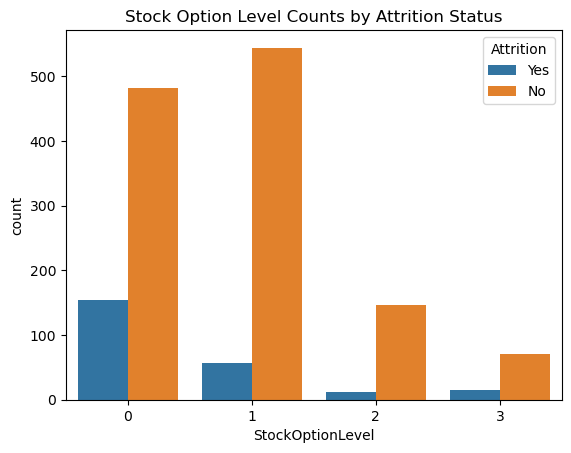

In [192]:
sns.countplot(x='StockOptionLevel', hue='Attrition', data=HR_Analytics)
plt.title('Stock Option Level Counts by Attrition Status')
plt.show()

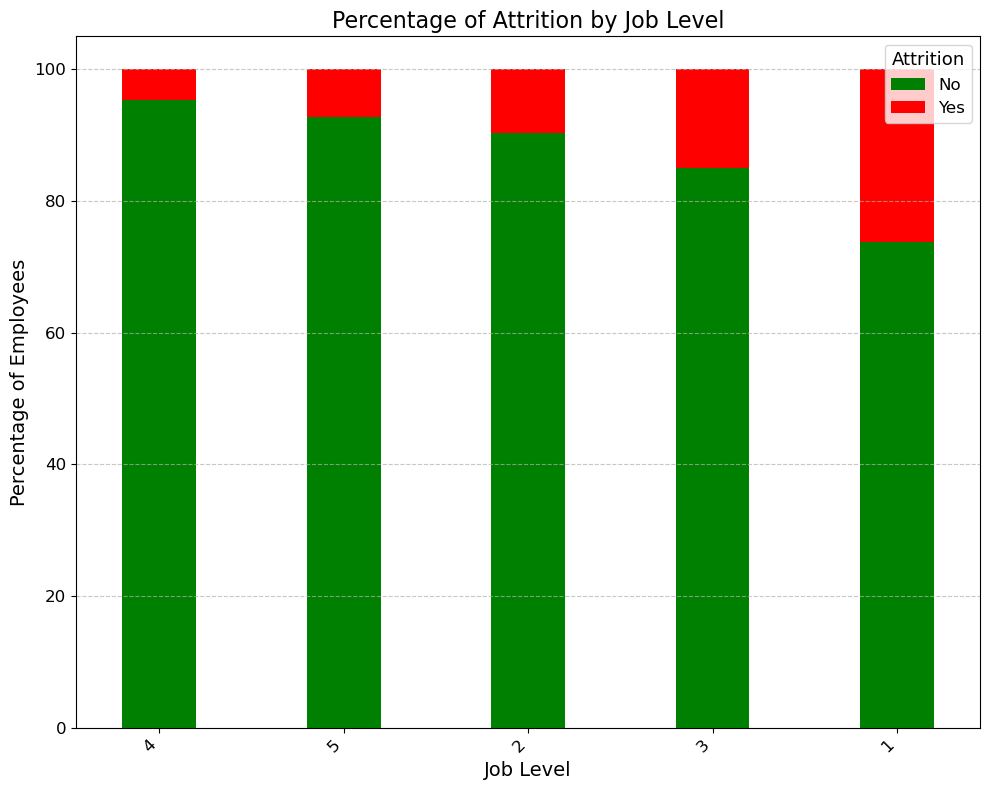

In [193]:
# Group by 'JobLevel' and 'Attrition', then count occurrences
joblevel_counts = HR_Analytics.groupby(['JobLevel', 'Attrition']).size().unstack(fill_value=0)

# Normalize the counts to percentages
joblevel_percentages = joblevel_counts.div(joblevel_counts.sum(axis=1), axis=0) * 100

# Sort the DataFrame based on the percentage of 'Yes' in attrition
joblevel_percentages_sorted = joblevel_percentages.sort_values(by='Yes')

# Define a visually appealing color palette
colors = ['green', 'red']

# Plotting
fig, ax = plt.subplots(figsize=(10, 8)) 
joblevel_percentages_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.4)

# Customize the plot
plt.title('Percentage of Attrition by Job Level', fontsize=16)
plt.xlabel('Job Level', fontsize=14)
plt.ylabel('Percentage of Employees', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Adjust the rotation and alignment of x-axis labels
plt.yticks(fontsize=12)
plt.legend(title='Attrition', fontsize=12, title_fontsize='13', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better readability
plt.tight_layout()

# Display the plot
plt.show()


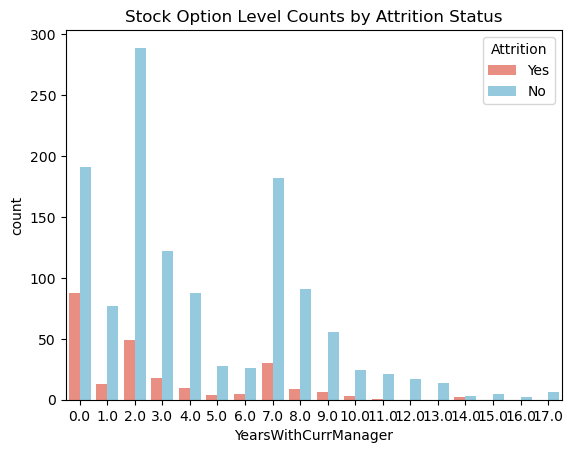

In [194]:
sns.countplot(x='YearsWithCurrManager', hue='Attrition', data=HR_Analytics, palette={'Yes': 'salmon', 'No': 'skyblue'})
plt.title('Stock Option Level Counts by Attrition Status')
plt.show()